In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [2]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'C:\Users\SHYAM\Downloads\gaussian_filtered_images\train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: ylabel='type'>

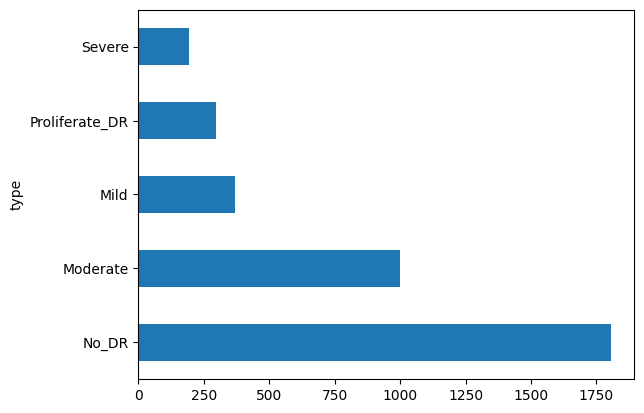

In [3]:
df['type'].value_counts().plot(kind='barh')

<Axes: ylabel='binary_type'>

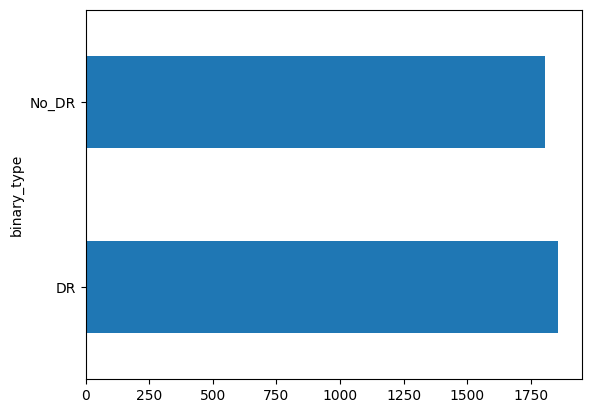

In [4]:
df['binary_type'].value_counts().plot(kind='barh')

In [5]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [6]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [7]:
# Copy images to respective working directory
src_dir = r'C:\Users\SHYAM\Downloads\gaussian_filtered_images\gaussian_filtered_images\gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [12]:
from sklearn.preprocessing import LabelEncoder

# Define your class names (replace with your actual class labels)
class_names = ["class_1", "class_2", "class_3"]  # Example class names

# Create and fit the encoder
encoder = LabelEncoder()
encoder.fit(class_names)

LabelEncoder()

In [8]:
import tensorflow as tf

def parse_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0  # Normalize
    return image, label

def build_dataset(image_paths, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(len(image_paths))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Create lists of image file paths and corresponding labels
import glob
import os

train_image_paths = glob.glob('train/*/*.png')
train_labels = [os.path.basename(os.path.dirname(path)) for path in train_image_paths]

val_image_paths = glob.glob('val/*/*.png')
val_labels = [os.path.basename(os.path.dirname(path)) for path in val_image_paths]

test_image_paths = glob.glob('test/*/*.png')
test_labels = [os.path.basename(os.path.dirname(path)) for path in test_image_paths]

# Convert labels to integers
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

train_labels = encoder.fit_transform(train_labels)
val_labels = encoder.transform(val_labels)
test_labels = encoder.transform(test_labels)

# Build datasets
train_dataset = build_dataset(train_image_paths, train_labels)
val_dataset = build_dataset(val_image_paths, val_labels, shuffle=False)
test_dataset = build_dataset(test_image_paths, test_labels, shuffle=False)


In [9]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load Pretrained ResNet50 (Exclude Top Layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model (optional)
base_model.trainable = False

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(len(encoder.classes_), activation='softmax')(x)  # Corrected this line

# Create Model
model = Model(inputs=base_model.input, outputs=x)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.5733 - loss: 0.7060 - val_accuracy: 0.8491 - val_loss: 0.5903
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 12573s 157s/step - accuracy: 0.8328 - loss: 0.5575 - val_accuracy: 0.8564 - val_loss: 0.4929
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - accuracy: 0.8639 - loss: 0.4569 - val_accuracy: 0.8509 - val_loss: 0.4283
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.8775 - loss: 0.3824 - val_accuracy: 0.8491 - val_loss: 0.3946
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.8612 - loss: 0.3640 - val_accuracy: 0.8473 - val_loss: 0.3897
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.8679 - loss: 0.3477 - val_accuracy: 0.8564 - val_loss: 0.3583
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.8677 - loss: 0.3404 - val_accuracy: 0.8582 - val_loss: 0.3564
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.8835 - loss: 0.3200 - val_accuracy: 0.8636

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Get True Labels and Predictions
y_true = np.concatenate([y.numpy() for _, y in test_dataset])  # Actual labels
y_pred_probs = model.predict(test_dataset)  # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Step 2: Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))


NameError: name 'test_dataset' is not defined

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.5582 - loss: 0.7166 - val_accuracy: 0.4500 - val_loss: 0.8470
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5697 - loss: 0.6968 - val_accuracy: 0.4500 - val_loss: 0.8390
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5676 - loss: 0.7022 - val_accuracy: 0.4500 - val_loss: 0.8315
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6009 - loss: 0.6943 - val_accuracy: 0.4500 - val_loss: 0.8249
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5811 - loss: 0.6913 - val_accuracy: 0.4500 - val_loss: 0.8186
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5676 - loss: 0.6912 - val_accuracy: 0.4500 - val_loss: 0.8135
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5613 - loss: 0.7019 - val_accuracy: 0.4500 - val_loss: 0.8083
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5645 - loss: 0.7002 - val_accuracy: 0.4500 - val_loss: 0.8039


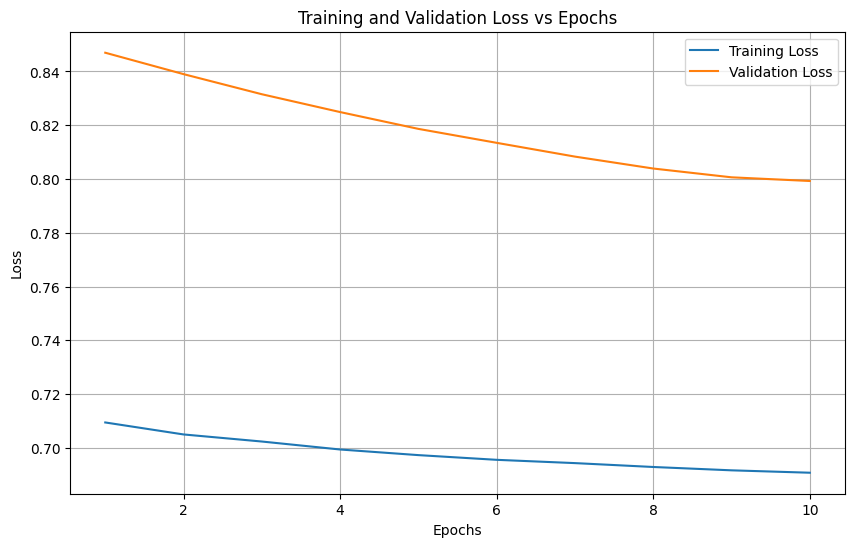

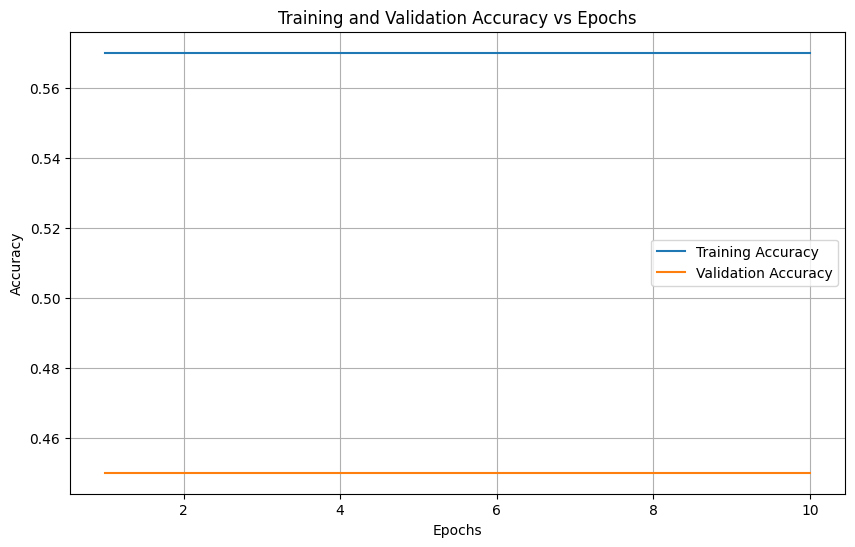

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

# Example data
X_train = np.random.rand(100, 8)
y_train = np.random.randint(2, size=(100, 1))
X_val = np.random.rand(20, 8)
y_val = np.random.randint(2, size=(20, 1))

# Example model
model = Sequential()
model.add(Dense(10, input_shape=(8,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Extract loss and accuracy values from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plot Loss vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
model.save('my_model.keras1')

# EfficientnetB2

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.5099 - loss: 0.6998 - val_accuracy: 0.4927 - val_loss: 0.6917
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.4969 - loss: 0.6966 - val_accuracy: 0.5073 - val_loss: 0.6936
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.5095 - loss: 0.6961 - val_accuracy: 0.5073 - val_loss: 0.6942
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.5238 - loss: 0.6948 - val_accuracy: 0.5655 - val_loss: 0.6872
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.5353 - loss: 0.6907 - val_accuracy: 0.5582 - val_loss: 0.6854
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.5255 - loss: 0.6920 - val_accuracy: 0.5073 - val_loss: 0.6900
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.5685 - loss: 0.6828 - val_accuracy: 0.6727 - val_loss: 0.6847
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.5320 - loss: 0.6896 - val_accuracy: 0.5855 - v

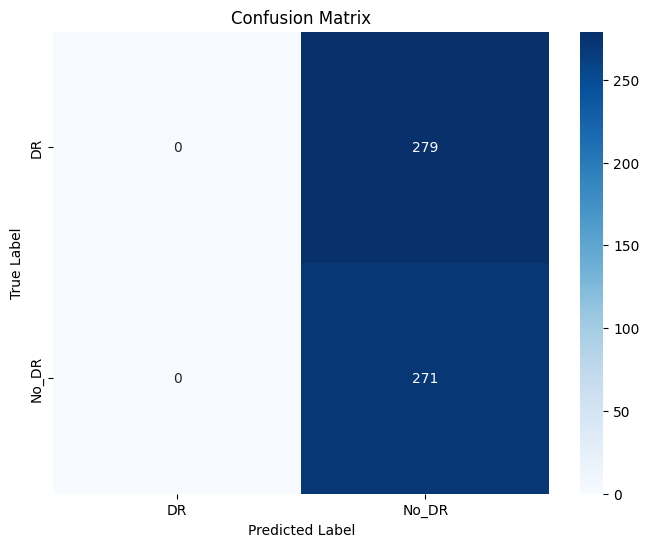

Classification Report:
              precision    recall  f1-score   support

          DR       0.00      0.00      0.00       279
       No_DR       0.49      1.00      0.66       271

    accuracy                           0.49       550
   macro avg       0.25      0.50      0.33       550
weighted avg       0.24      0.49      0.33       550



C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load Pretrained EfficientNetB2 (without the top layer)
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (optional)
base_model.trainable = False

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Regularization to prevent overfitting
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(len(encoder.classes_), activation='softmax')(x)  # Output layer

# Create Model
model = Model(inputs=base_model.input, outputs=x)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Step 1: Get True Labels and Predictions
y_true = np.concatenate([y.numpy() for _, y in test_dataset])  # Actual labels
y_pred_probs = model.predict(test_dataset)  # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Step 2: Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.4990 - loss: 0.7035 - val_accuracy: 0.2500 - val_loss: 0.7449
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4875 - loss: 0.7031 - val_accuracy: 0.2500 - val_loss: 0.7458
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5271 - loss: 0.6959 - val_accuracy: 0.2500 - val_loss: 0.7446
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5240 - loss: 0.6953 - val_accuracy: 0.2500 - val_loss: 0.7416
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4771 - loss: 0.7078 - val_accuracy: 0.2500 - val_loss: 0.7372
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4917 - loss: 0.7015 - val_accuracy: 0.2500 - val_loss: 0.7327
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4948 - loss: 0.6981 - val_accuracy: 0.2500 - val_loss: 0.7288
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5052 - loss: 0.6973 - val_accuracy: 0.3000 - val_loss: 0.7248

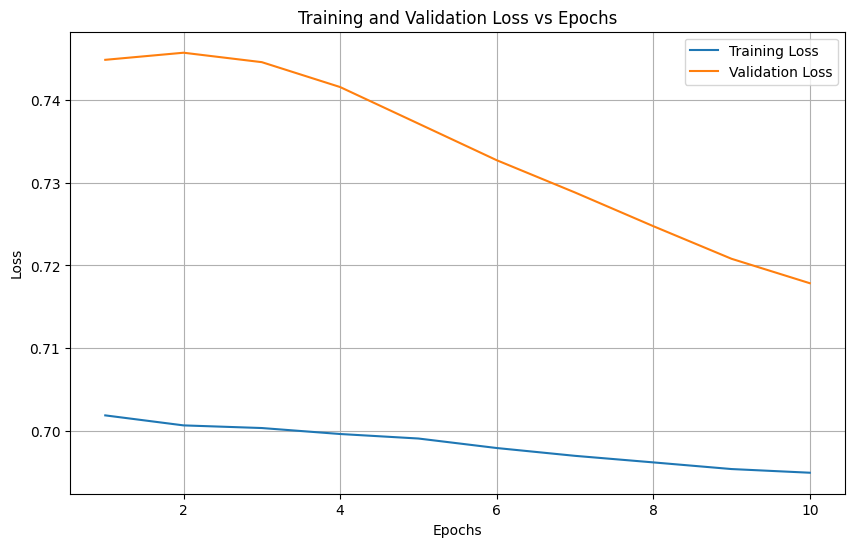

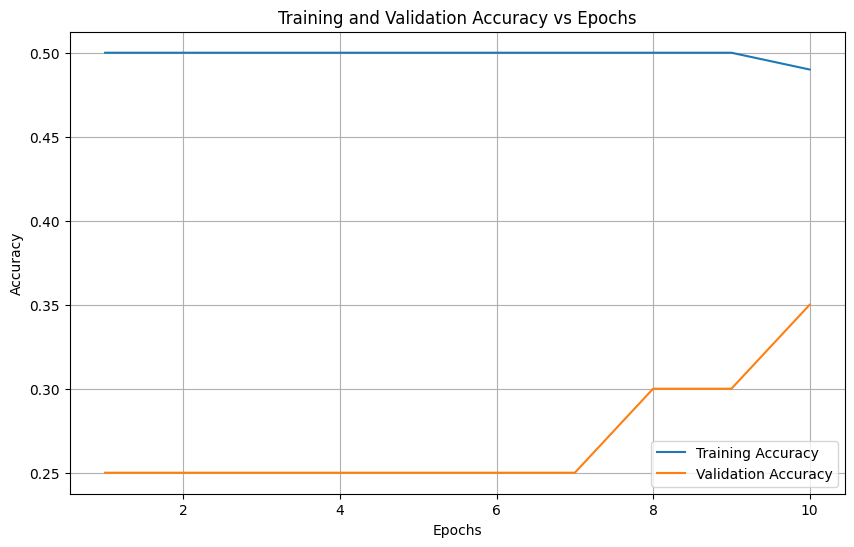

In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

# Example data
X_train = np.random.rand(100, 8)
y_train = np.random.randint(2, size=(100, 1))
X_val = np.random.rand(20, 8)
y_val = np.random.randint(2, size=(20, 1))

# Example model
model = Sequential()
model.add(Dense(10, input_shape=(8,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Extract loss and accuracy values from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plot Loss vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()




In [14]:
model.save('my_model.keras2')

# Densenet121

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.6382 - loss: 0.6921 - val_accuracy: 0.9000 - val_loss: 0.2471
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.8960 - loss: 0.2732 - val_accuracy: 0.9345 - val_loss: 0.2048
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.9254 - loss: 0.2218 - val_accuracy: 0.9455 - val_loss: 0.1857
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.9360 - loss: 0.2020 - val_accuracy: 0.9455 - val_loss: 0.1782
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.9385 - loss: 0.1917 - val_accuracy: 0.9527 - val_loss: 0.1690
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.9455 - loss: 0.1758 - val_accuracy: 0.9527 - val_loss: 0.1616
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.9483 - loss: 0.1603 - val_accuracy: 0.9545 - val_loss: 0.1554
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.9577 - loss: 0.1450 - val_accuracy: 0.9564 - v

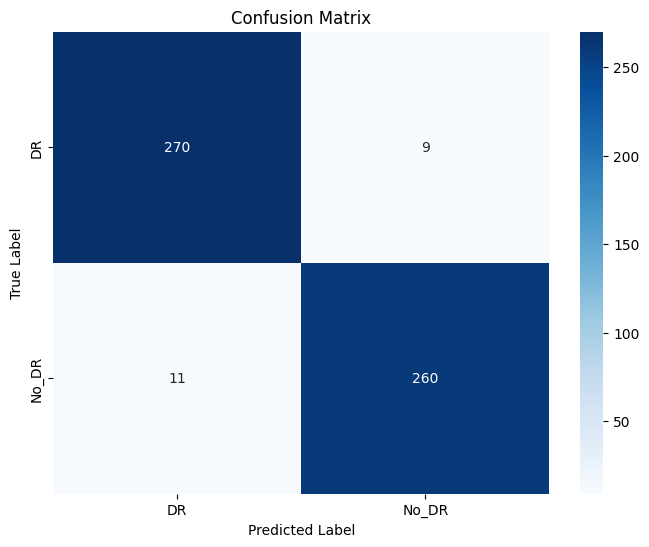

Classification Report:
              precision    recall  f1-score   support

          DR       0.96      0.97      0.96       279
       No_DR       0.97      0.96      0.96       271

    accuracy                           0.96       550
   macro avg       0.96      0.96      0.96       550
weighted avg       0.96      0.96      0.96       550



In [15]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load Pretrained DenseNet121 (without the top layer)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (optional)
base_model.trainable = False

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Regularization to prevent overfitting
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(len(encoder.classes_), activation='softmax')(x)  # Output layer

# Create Model
model = Model(inputs=base_model.input, outputs=x)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Step 1: Get True Labels and Predictions
y_true = np.concatenate([y.numpy() for _, y in test_dataset])  # Actual labels
y_pred_probs = model.predict(test_dataset)  # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Step 2: Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.6086 - loss: 0.6806 - val_accuracy: 0.3500 - val_loss: 0.7153
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6126 - loss: 0.6836 - val_accuracy: 0.3500 - val_loss: 0.7154
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6397 - loss: 0.6724 - val_accuracy: 0.3500 - val_loss: 0.7152
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5970 - loss: 0.6832 - val_accuracy: 0.3500 - val_loss: 0.7149
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6468 - loss: 0.6757 - val_accuracy: 0.3500 - val_loss: 0.7150
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6260 - loss: 0.6785 - val_accuracy: 0.4000 - val_loss: 0.7147
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6984 - loss: 0.6761 - val_accuracy: 0.4000 - val_loss: 0.7146
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6671 - loss: 0.6741 - val_accuracy: 0.3500 - val_loss: 0.7149

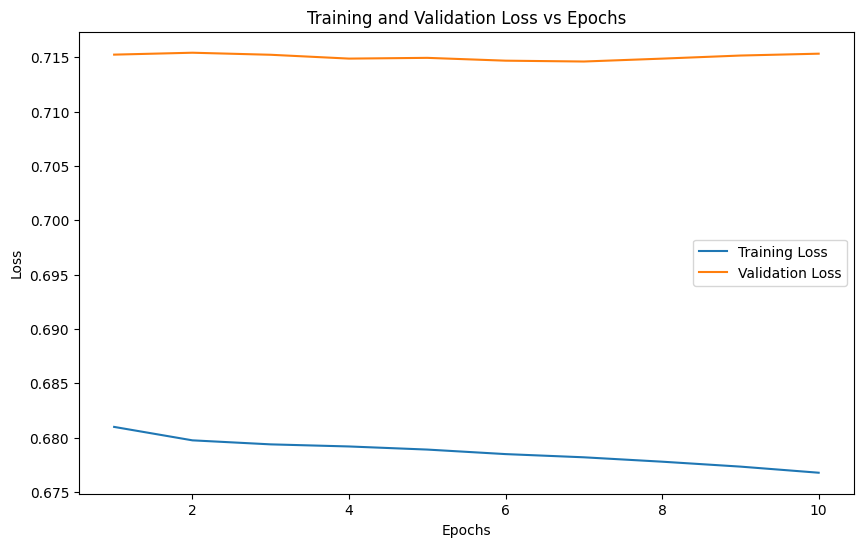

In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

# Example data
X_train = np.random.rand(100, 8)
y_train = np.random.randint(2, size=(100, 1))
X_val = np.random.rand(20, 8)
y_val = np.random.randint(2, size=(20, 1))

# Example model
model = Sequential()
model.add(Dense(10, input_shape=(8,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Extract loss values from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot the training loss vs epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.legend()
plt.show()


In [16]:
model.save('my_model.keras3')

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.7292 - loss: 0.5425 - val_accuracy: 0.9273 - val_loss: 0.2212
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.9145 - loss: 0.2235 - val_accuracy: 0.9182 - val_loss: 0.2265
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9202 - loss: 0.2278 - val_accuracy: 0.9364 - val_loss: 0.1765
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9384 - loss: 0.1759 - val_accuracy: 0.9382 - val_loss: 0.1793
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.9404 - loss: 0.1687 - val_accuracy: 0.9436 - val_loss: 0.1673
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9504 - loss: 0.1636 - val_accuracy: 0.9291 - val_loss: 0.1640
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9453 - loss: 0.1570 - val_accuracy: 0.9455 - val_loss: 0.1530
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9466 - loss: 0.1576 - val_accuracy: 0.9509 - val_l

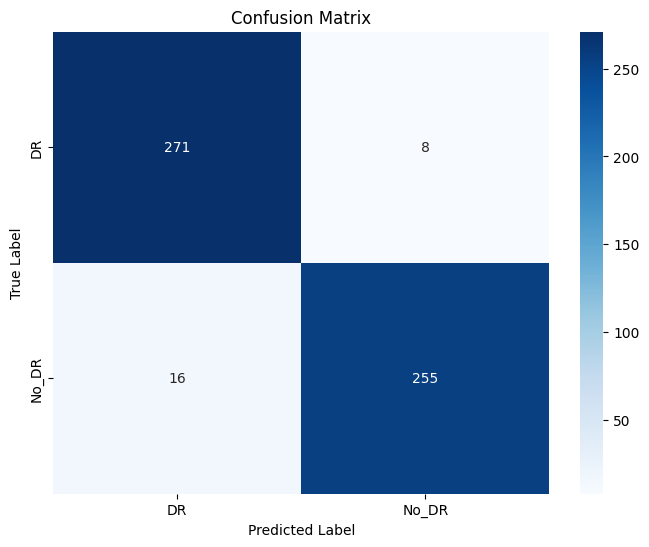

Classification Report:
              precision    recall  f1-score   support

          DR       0.94      0.97      0.96       279
       No_DR       0.97      0.94      0.96       271

    accuracy                           0.96       550
   macro avg       0.96      0.96      0.96       550
weighted avg       0.96      0.96      0.96       550



In [17]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load Pretrained InceptionV3 (without the top layer)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (optional)
base_model.trainable = False

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Regularization to prevent overfitting
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(len(encoder.classes_), activation='softmax')(x)  # Output layer

# Create Model
model = Model(inputs=base_model.input, outputs=x)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Step 1: Get True Labels and Predictions
y_true = np.concatenate([y.numpy() for _, y in test_dataset])  # Actual labels
y_pred_probs = model.predict(test_dataset)  # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Step 2: Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.5129 - loss: 0.7028 - val_accuracy: 0.3500 - val_loss: 0.7059
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5877 - loss: 0.6831 - val_accuracy: 0.4000 - val_loss: 0.7051
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5563 - loss: 0.6867 - val_accuracy: 0.4000 - val_loss: 0.7047
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5334 - loss: 0.6946 - val_accuracy: 0.4000 - val_loss: 0.7049
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5521 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.7047
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5533 - loss: 0.6905 - val_accuracy: 0.5000 - val_loss: 0.7044
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5440 - loss: 0.6842 - val_accuracy: 0.5000 - val_loss: 0.7043
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5398 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.7040

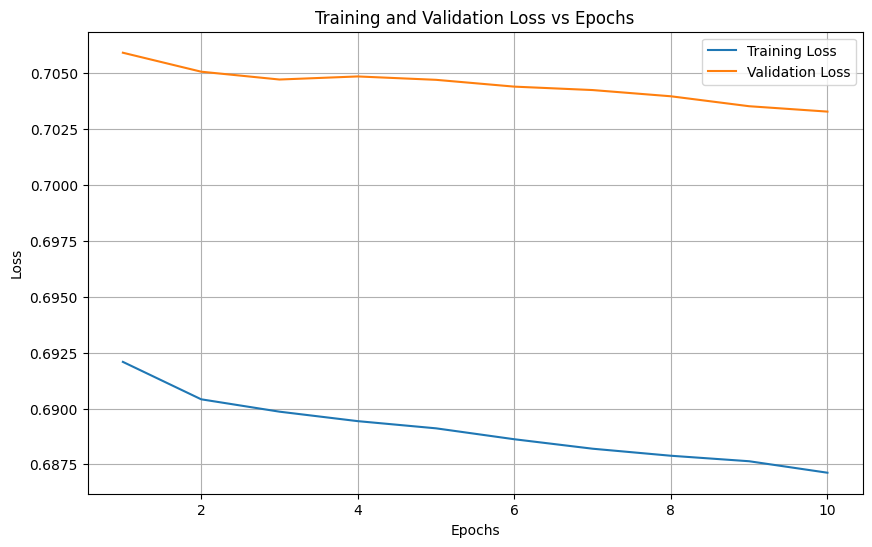

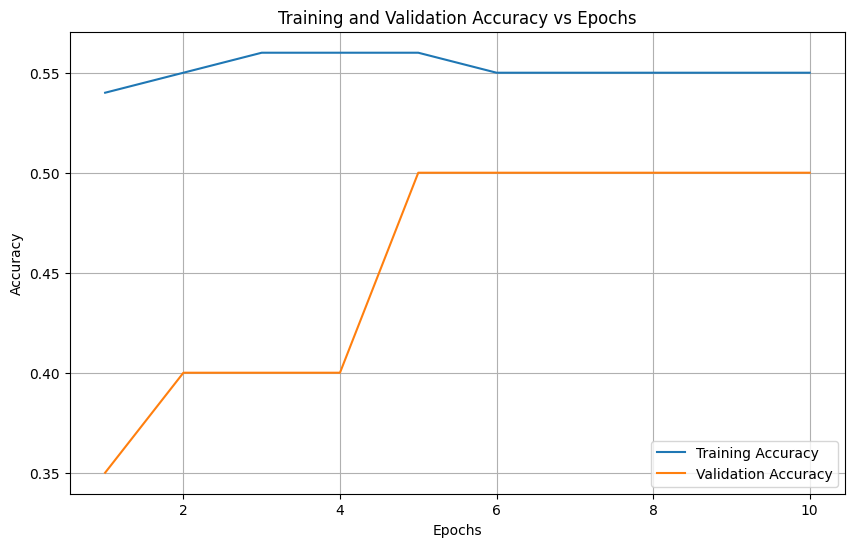

In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

# Example data
X_train = np.random.rand(100, 8)
y_train = np.random.randint(2, size=(100, 1))
X_val = np.random.rand(20, 8)
y_val = np.random.randint(2, size=(20, 1))

# Example model
model = Sequential()
model.add(Dense(10, input_shape=(8,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Extract loss and accuracy values from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plot Loss vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
model.save('my_model.keras4')

# Voter Ensemble

Training ResNet50...
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 85s 11s/step - accuracy: 0.4109 - loss: 2.5696 - val_accuracy: 0.3000 - val_loss: 2.4681
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 9s/step - accuracy: 0.4427 - loss: 2.2781 - val_accuracy: 0.3000 - val_loss: 2.4479
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 8s/step - accuracy: 0.5860 - loss: 2.0811 - val_accuracy: 0.3000 - val_loss: 2.4222
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 9s/step - accuracy: 0.7549 - loss: 1.9253 - val_accuracy: 0.3000 - val_loss: 2.4504
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.8087 - loss: 1.8562 - val_accuracy: 0.3000 - val_loss: 2.5156
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 8s/step - accuracy: 0.7929 - loss: 1.8196 - val_accuracy: 0.3000 - val_loss: 2.6612
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 10s/step - accuracy: 0.8372 - loss: 1.7205 - val_accuracy: 0.3000 - val_loss: 2.8442
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step - accuracy: 0.8348 - loss: 1.6997 - val_accuracy: 0.3000 - va

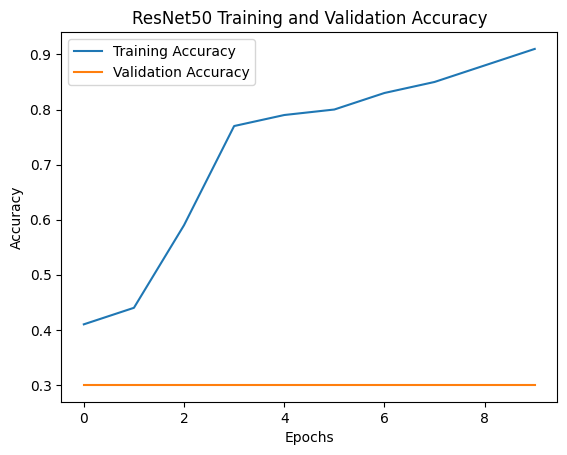

Training EfficientNetB2...
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 135s 14s/step - accuracy: 0.2497 - loss: 2.4430 - val_accuracy: 0.3000 - val_loss: 2.3551
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 9s/step - accuracy: 0.3247 - loss: 2.3718 - val_accuracy: 0.3000 - val_loss: 2.3584
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - accuracy: 0.3174 - loss: 2.3631 - val_accuracy: 0.3000 - val_loss: 2.3681
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 11s/step - accuracy: 0.3462 - loss: 2.3604 - val_accuracy: 0.3000 - val_loss: 2.3788
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 11s/step - accuracy: 0.2938 - loss: 2.3571 - val_accuracy: 0.3000 - val_loss: 2.3724
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 10s/step - accuracy: 0.2924 - loss: 2.3961 - val_accuracy: 0.3000 - val_loss: 2.3706
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 10s/step - accuracy: 0.3256 - loss: 2.3381 - val_accuracy: 0.3000 - val_loss: 2.3698
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 10s/step - accuracy: 0.2969 - loss: 2.3655 - val_accuracy: 

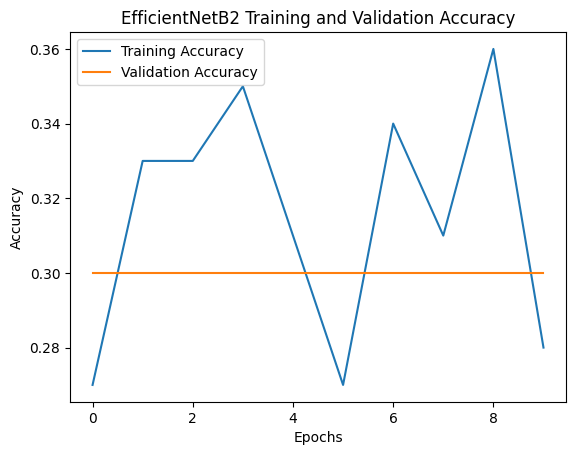

Training DenseNet121...
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 171s 16s/step - accuracy: 0.4100 - loss: 2.8237 - val_accuracy: 0.3000 - val_loss: 2.3183
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 55s 12s/step - accuracy: 0.3914 - loss: 2.5368 - val_accuracy: 0.2500 - val_loss: 2.3714
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 50s 11s/step - accuracy: 0.4741 - loss: 2.4623 - val_accuracy: 0.2500 - val_loss: 2.4481
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 62s 14s/step - accuracy: 0.4701 - loss: 2.2591 - val_accuracy: 0.2500 - val_loss: 2.4846
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 12s/step - accuracy: 0.5339 - loss: 2.2039 - val_accuracy: 0.2500 - val_loss: 2.4774
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 53s 12s/step - accuracy: 0.4929 - loss: 2.2535 - val_accuracy: 0.2500 - val_loss: 2.4856
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 12s/step - accuracy: 0.5968 - loss: 1.9676 - val_accuracy: 0.2500 - val_loss: 2.5125
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 54s 12s/step - accuracy: 0.6630 - loss: 1.8985 - val_accuracy: 0

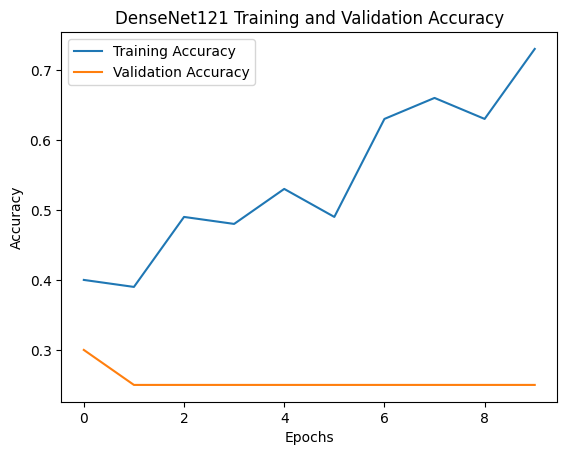

Training InceptionV3...
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 83s 6s/step - accuracy: 0.3072 - loss: 2.5121 - val_accuracy: 0.3000 - val_loss: 2.3559
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.4527 - loss: 2.4163 - val_accuracy: 0.3000 - val_loss: 2.3899
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5238 - loss: 2.2713 - val_accuracy: 0.3000 - val_loss: 2.3989
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.6560 - loss: 2.1231 - val_accuracy: 0.3000 - val_loss: 2.3496
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.6381 - loss: 2.0602 - val_accuracy: 0.5000 - val_loss: 2.3229
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.6659 - loss: 2.0333 - val_accuracy: 0.5000 - val_loss: 2.3334
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.6739 - loss: 1.9785 - val_accuracy: 0.3000 - val_loss: 2.3866
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.6995 - loss: 1.9570 - val_accuracy: 0.3000 - v

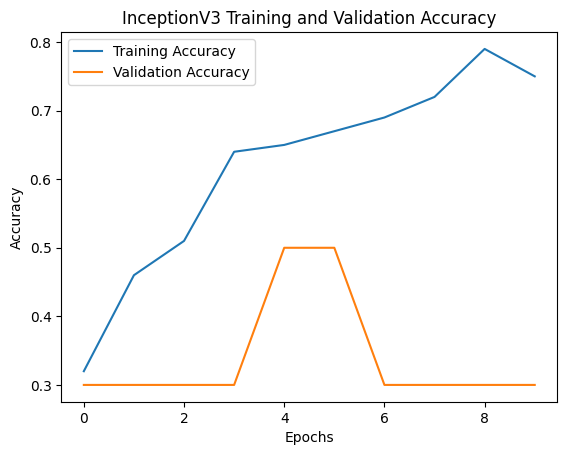

Evaluating ResNet50...
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


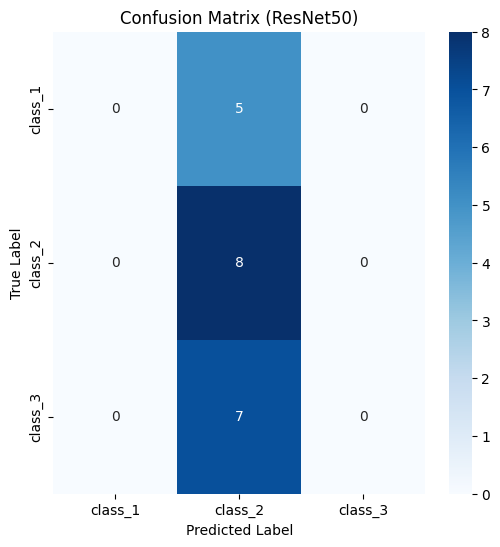

Classification Report (ResNet50):
              precision    recall  f1-score   support

     class_1       0.00      0.00      0.00         5
     class_2       0.40      1.00      0.57         8
     class_3       0.00      0.00      0.00         7

    accuracy                           0.40        20
   macro avg       0.13      0.33      0.19        20
weighted avg       0.16      0.40      0.23        20

Evaluating EfficientNetB2...


C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


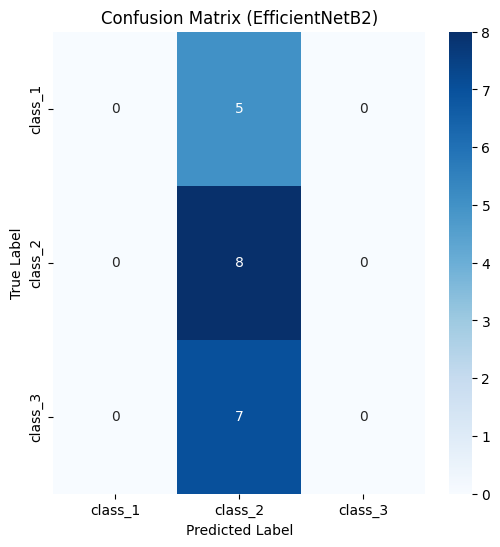

Classification Report (EfficientNetB2):
              precision    recall  f1-score   support

     class_1       0.00      0.00      0.00         5
     class_2       0.40      1.00      0.57         8
     class_3       0.00      0.00      0.00         7

    accuracy                           0.40        20
   macro avg       0.13      0.33      0.19        20
weighted avg       0.16      0.40      0.23        20

Evaluating DenseNet121...


C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


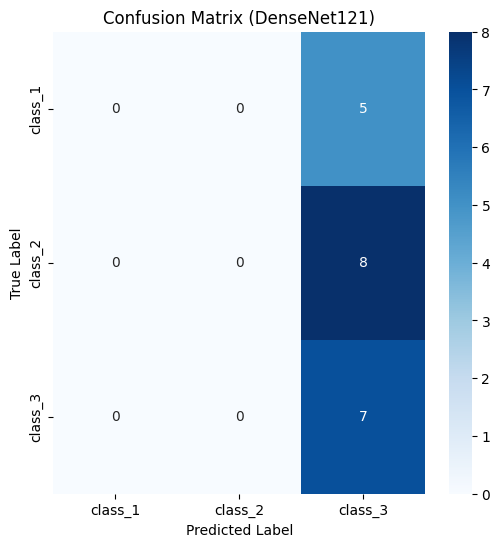

Classification Report (DenseNet121):
              precision    recall  f1-score   support

     class_1       0.00      0.00      0.00         5
     class_2       0.00      0.00      0.00         8
     class_3       0.35      1.00      0.52         7

    accuracy                           0.35        20
   macro avg       0.12      0.33      0.17        20
weighted avg       0.12      0.35      0.18        20

Evaluating InceptionV3...


C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


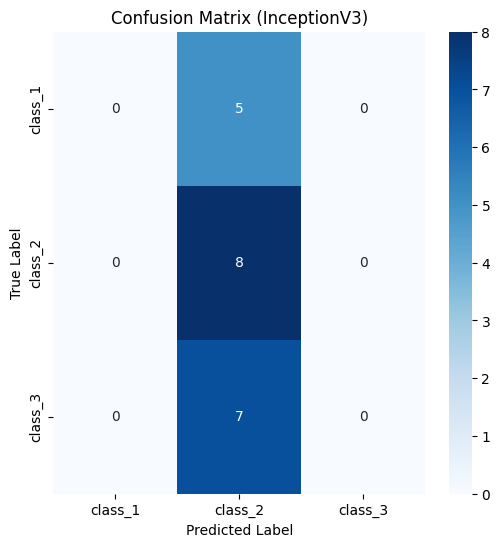

Classification Report (InceptionV3):
              precision    recall  f1-score   support

     class_1       0.00      0.00      0.00         5
     class_2       0.40      1.00      0.57         8
     class_3       0.00      0.00      0.00         7

    accuracy                           0.40        20
   macro avg       0.13      0.33      0.19        20
weighted avg       0.16      0.40      0.23        20



C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


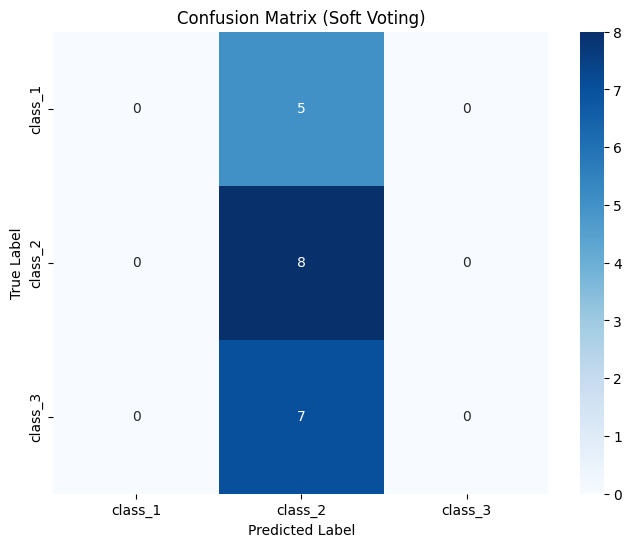

Classification Report (Soft Voting):
              precision    recall  f1-score   support

     class_1       0.00      0.00      0.00         5
     class_2       0.40      1.00      0.57         8
     class_3       0.00      0.00      0.00         7

    accuracy                           0.40        20
   macro avg       0.13      0.33      0.19        20
weighted avg       0.16      0.40      0.23        20



C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SHYAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet50, EfficientNetB2, DenseNet121, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Define your class names (replace with your actual class labels)
class_names = ["class_1", "class_2", "class_3"]  # Example class names

# Create and fit the encoder
encoder = LabelEncoder()
encoder.fit(class_names)

# Example: Load your data (replace with your actual data)
X_train = np.random.rand(100, 224, 224, 3)  # 100 training images of size (224, 224, 3)
y_train = np.random.randint(0, len(encoder.classes_), size=(100,))  # 100 training labels
X_val = np.random.rand(20, 224, 224, 3)  # 20 validation images
y_val = np.random.randint(0, len(encoder.classes_), size=(20,))  # 20 validation labels
X_test = np.random.rand(20, 224, 224, 3)  # 20 test images
y_test = np.random.randint(0, len(encoder.classes_), size=(20,))  # 20 test labels

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Create TensorFlow datasets
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load Pretrained Models (without top layers)
def load_pretrained_model(model_class, input_shape=(224, 224, 3)):
    base_model = model_class(weights="imagenet", include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(x)  # Smaller dense layer with L2 regularization
    x = Dropout(0.5)(x)  # Dropout
    x = Dense(len(encoder.classes_), activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Load models
models = {
    "ResNet50": load_pretrained_model(ResNet50),
    "EfficientNetB2": load_pretrained_model(EfficientNetB2),
    "DenseNet121": load_pretrained_model(DenseNet121),
    "InceptionV3": load_pretrained_model(InceptionV3)
}

# Compile models
for model in models.values():
    model.compile(optimizer=Adam(learning_rate=0.00001),  # Smaller learning rate
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

# Train individual models
for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1)
    print(f"Training completed for {name}.\n")

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{name} Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Evaluate individual models
individual_predictions = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    y_pred_probs = model.predict(test_dataset)  # Softmax probabilities
    y_pred = np.argmax(y_pred_probs, axis=1)   # Convert to class labels
    individual_predictions[name] = y_pred

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({name})")
    plt.show()

    # Print classification report
    print(f"Classification Report ({name}):")
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Soft Voting (Average Probabilities)
y_pred_probs_ensemble = np.mean([model.predict(test_dataset) for model in models.values()], axis=0)
y_pred_soft = np.argmax(y_pred_probs_ensemble, axis=1)

# Compute Confusion Matrix for Soft Voting
cm = confusion_matrix(y_test, y_pred_soft)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Soft Voting)")
plt.show()

# Print Classification Report
print("Classification Report (Soft Voting):")
print(classification_report(y_test, y_pred_soft, target_names=encoder.classes_))

In [ ]:
model.save('my_model.keras')

In [ ]:
pip install gradio

In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained CNN model
model = load_model("CNN.h5")  # Ensure CNN.h5 is in the correct path

# Function to preprocess input image
def preprocess_image(img):
    img = img.resize((224, 224))  # Resize to match model input size
    img = np.array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to predict DR or No_DR
def predict_dr(img):
    img = preprocess_image(img)
    prediction = model.predict(img)
    class_labels = ["DR", "No_DR"]
    return class_labels[np.argmax(prediction)]

# Gradio Interface
iface = gr.Interface(
    fn=predict_dr,
    inputs=gr.Image(type="pil"),  # Accepts image input
    outputs=gr.Label(),  # Displays predicted label
    title="Diabetic Retinopathy Detection",
    description="Upload a retina scan image to check for DR (Diabetic Retinopathy) or No_DR."
)

# Launch Gradio App
iface.launch()
